In [1]:
import numpy as np
import random as rnd
from math import log, sin, e, cos
from Timage import Timage
from PIL import Image, ImageFilter
import scipy.io as sc
from tqdm import trange

## Обработка генерируемого изображения

In [9]:
f = lambda i, j: 255 * abs(sin((i * j)))

In [11]:
f = lambda i, j: 255 if ((i-250)**2 + (j-250)**2) <= 15**2 else 0

In [ ]:
pixels = np.array([[f(i, j) for j in range(500)] for i in range(500)], dtype=np.float32)
t1 = Timage(array=pixels)
t1

In [ ]:
t1.median_blur(radius=15).image.show()

100%|██████████| 1000/1000 [02:56<00:00,  5.67it/s]


In [17]:
g = t1.gaussian_blur(blur=2, radius=60)

100%|██████████| 500/500 [11:03<00:00,  1.33s/it]


## Обработка изображения

In [76]:
tm = Timage(image=Image.open("resources/images/vinland.png"), dtype=np.float32)
tm.gaussian_blur()


Gaussian blur:  44%|████▎     | 472/1079 [00:06<00:08, 70.87it/s]


KeyboardInterrupt: 

In [2]:
416*442*1000

183872000

In [3]:
m = sc.loadmat('resources/sector_one.mat')
def get_timage(n):
    global m
    return Timage(array=np.array([[m['A'][j][i][n] for j in range(416)] for i in range(442)], dtype=np.float32))

In [ ]:
array = np.zeros((442, 416), dtype=np.float32)
first = get_timage(0).array
for n in trange(100, 200):
    curr_timage = get_timage(n).array
    for i in range(442):
        for j in range(416):
            array[i][j] = array[i][j] + curr_timage[i][j] - first[i][j]
            
mx = max(max(row) for row in array)
for i in range(442):
    for j in range(416):
        array[i][j] = 255*array[i][j] / mx

Timage(array=array)

In [73]:
def contrast(arr, level):
    m, n = len(arr), len(arr[0])
    #flat = []
    #for row in arr:
    #    flat.extend(row)
    #mean = sorted(flat)[len(flat)//2]
    mean = sum(sum(row) for row in arr) / (m*n)
    f = lambda x: (x - mean) / (1 - level) + mean
    new = arr.copy()
    for i in range(m):
        for j in range(n):
            new[i][j] = min(255, max(0,   f(float(arr[i][j]))  ))
    return new

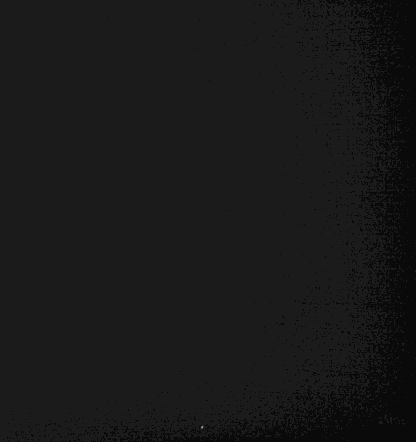

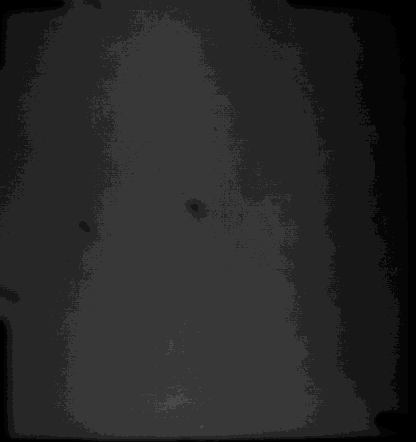

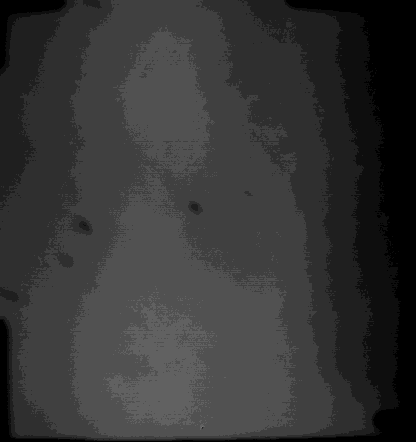

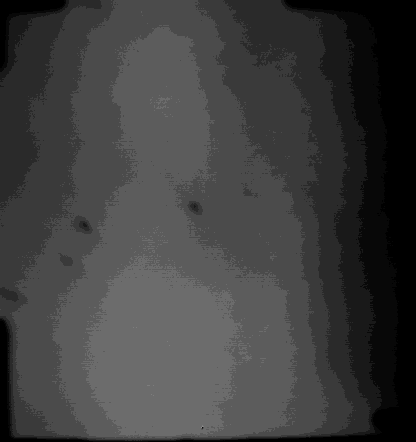

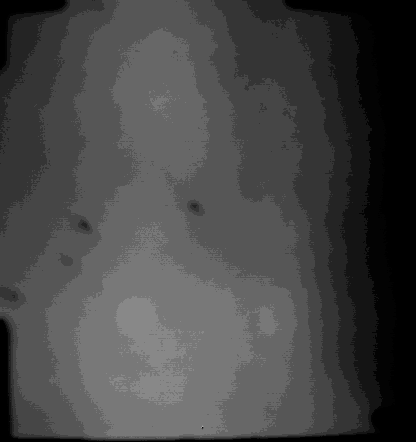

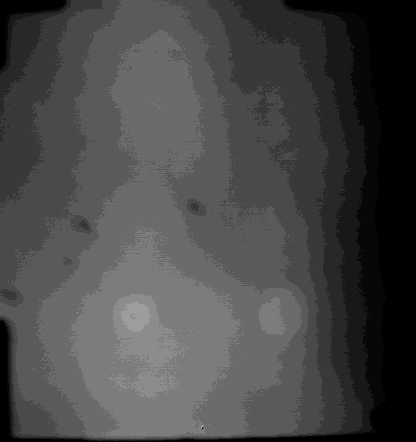

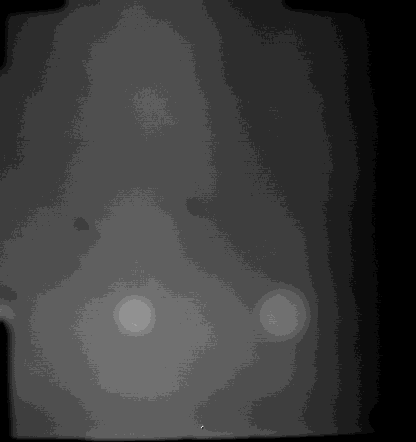

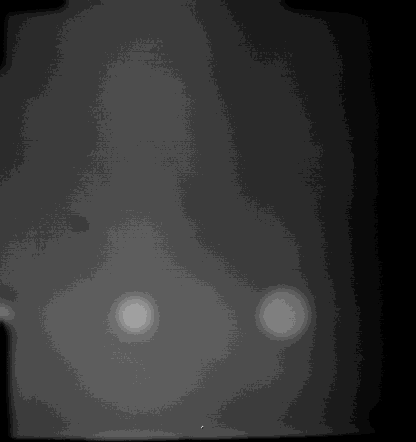

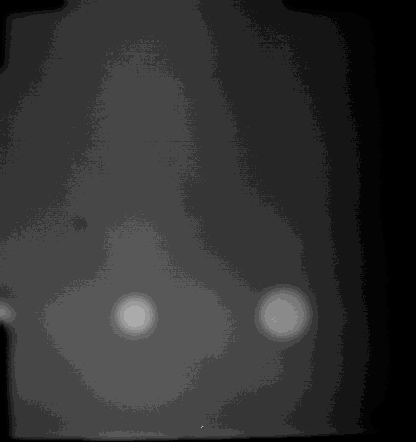

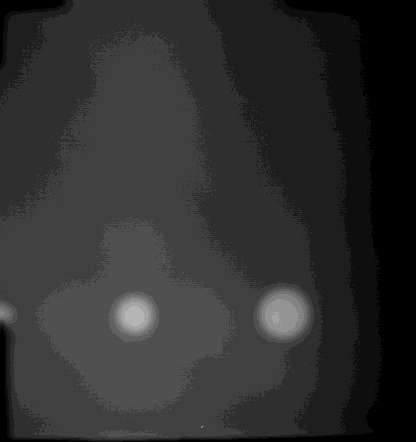

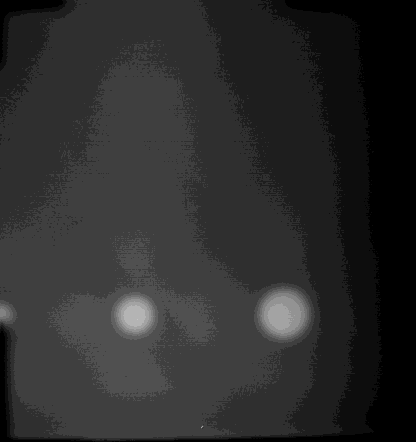

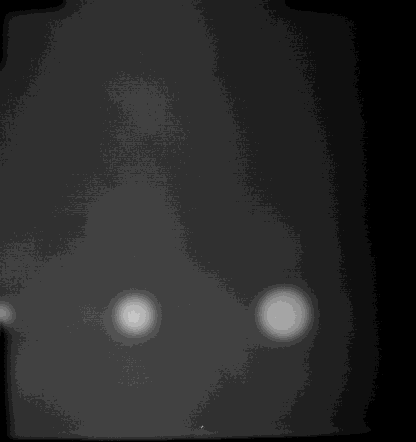

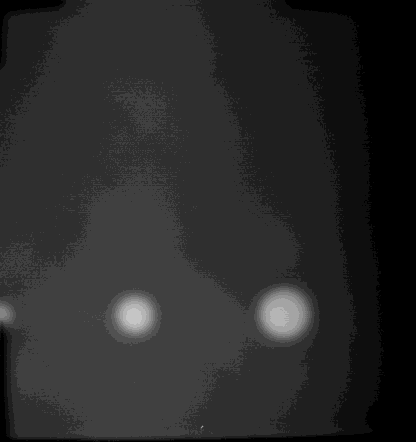

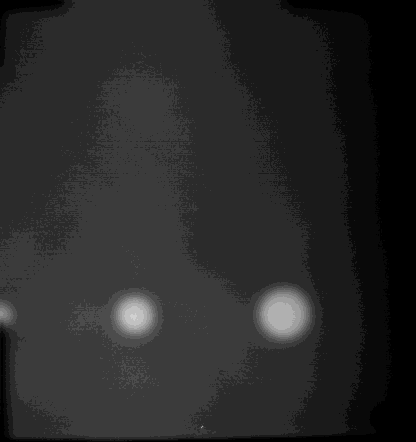

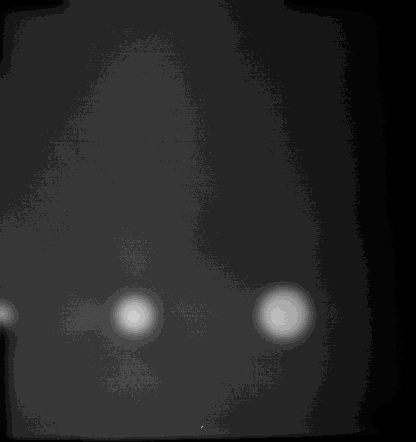

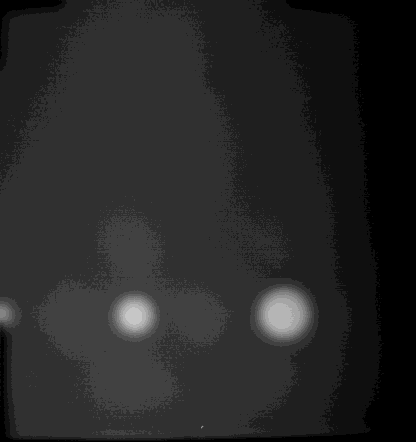

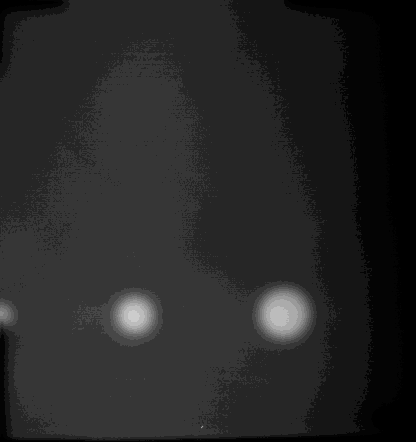

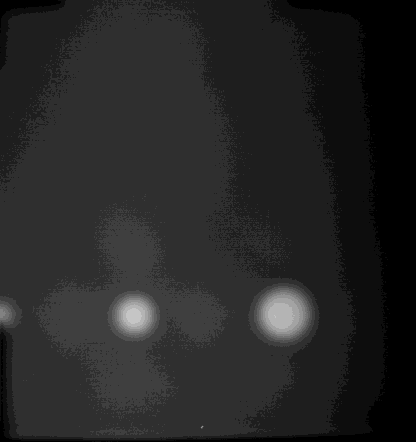

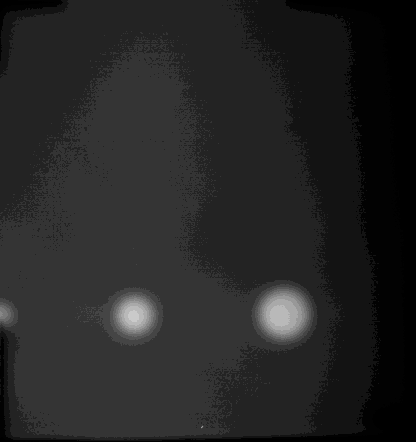

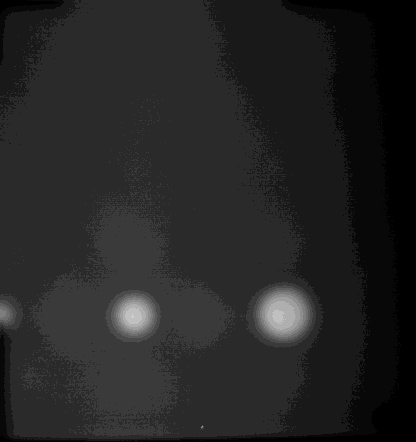

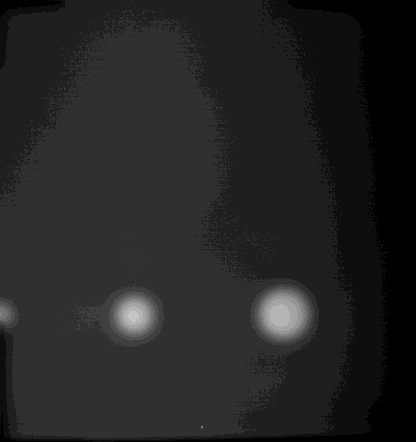

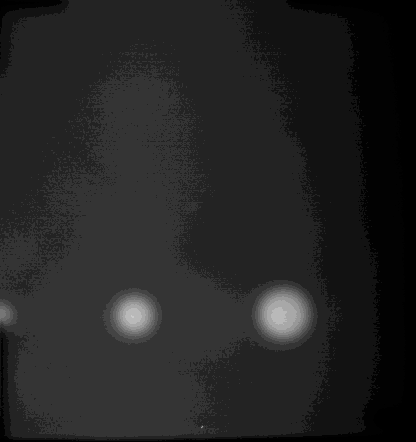

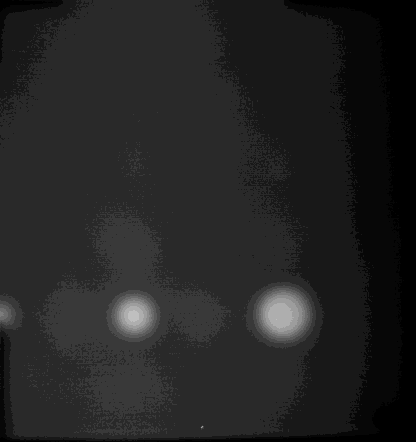

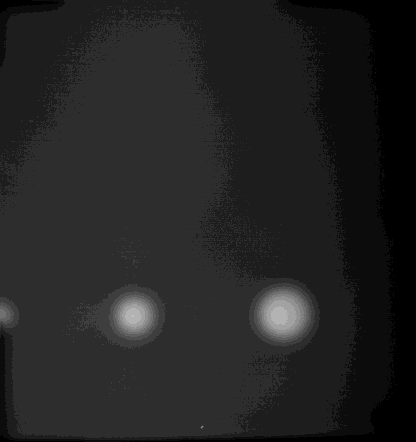

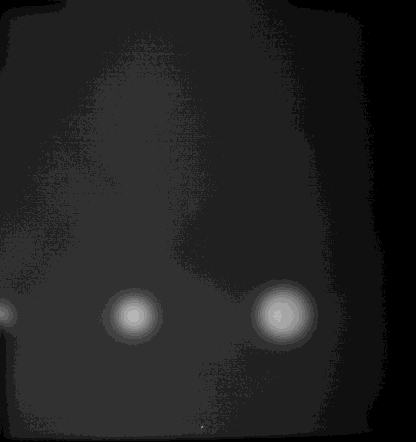

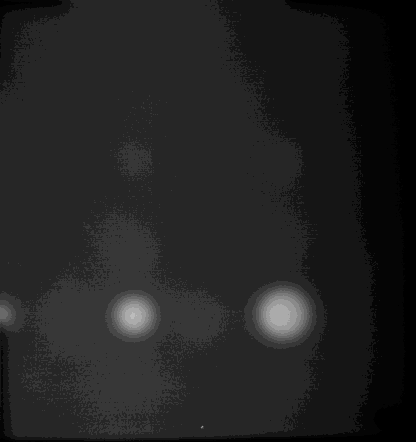

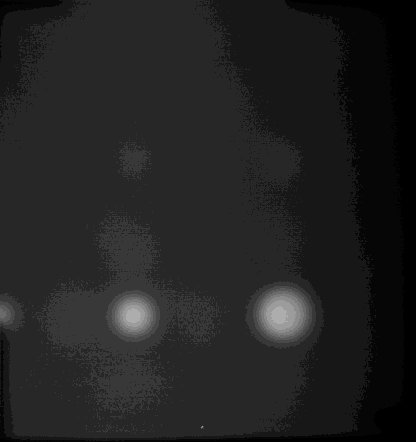

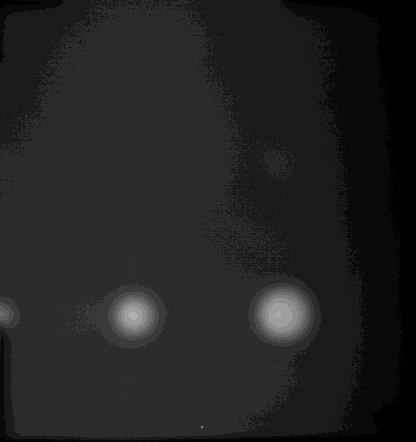

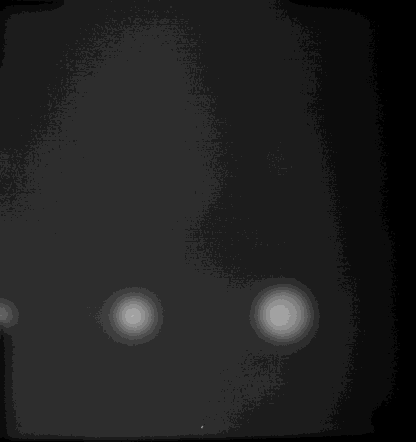

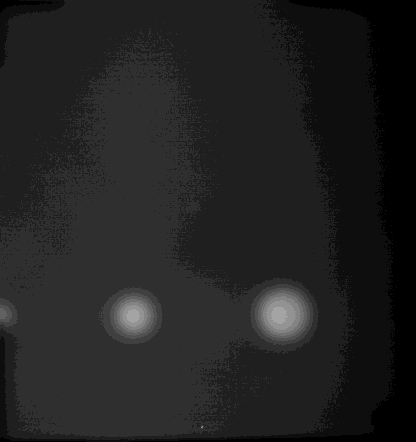

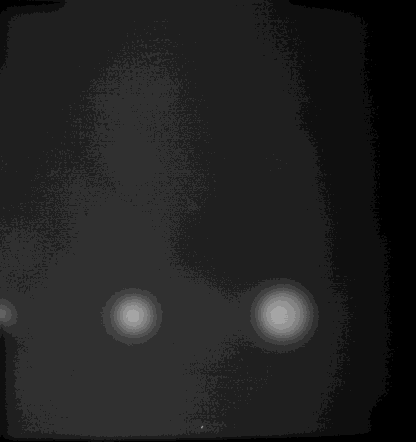

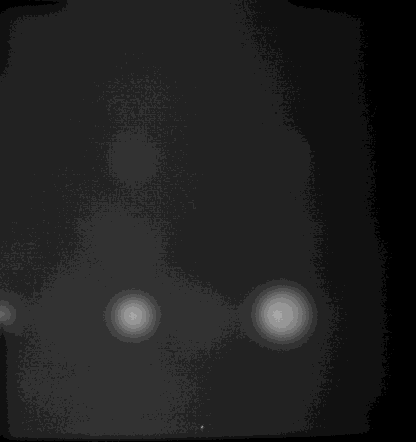

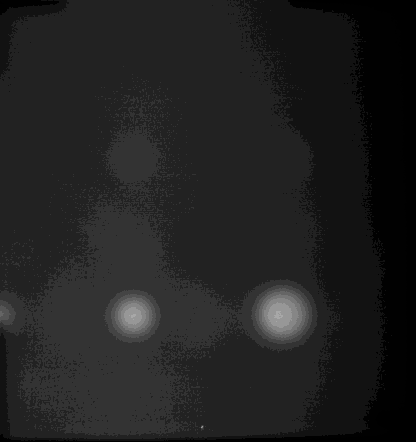

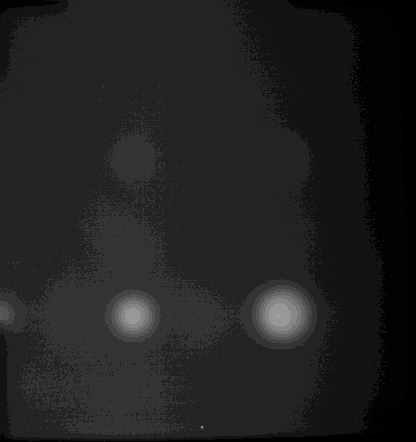

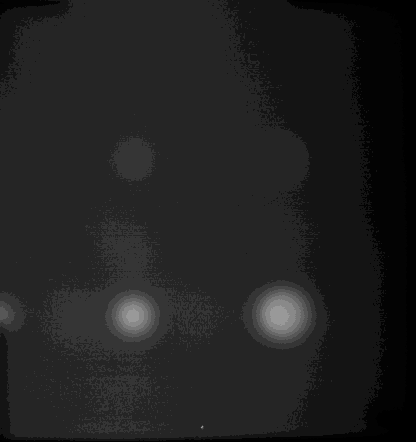

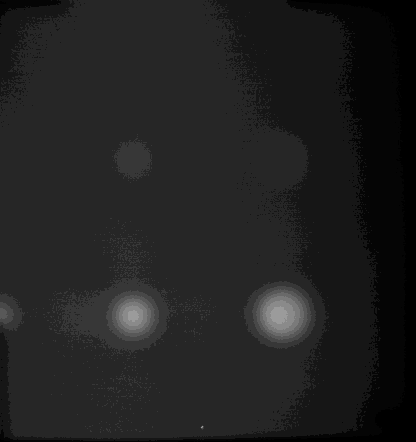

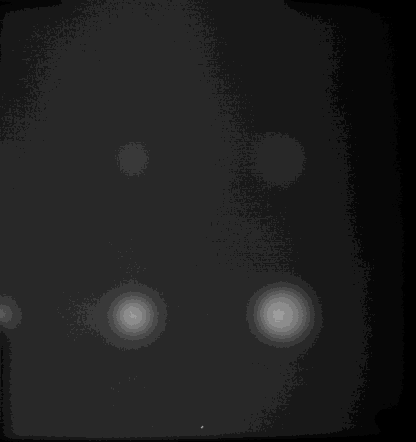

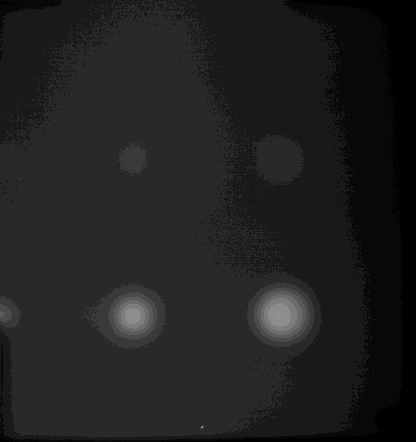

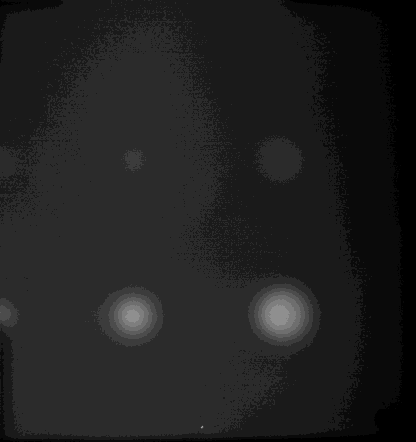

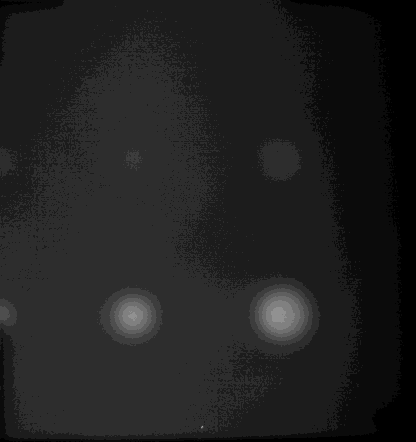

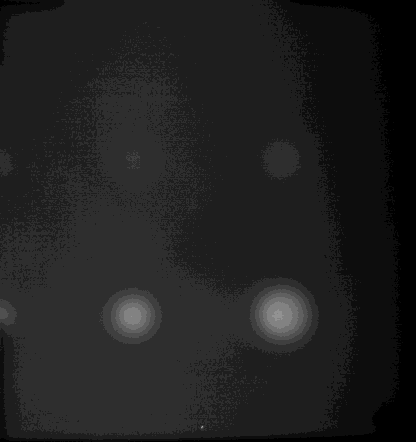

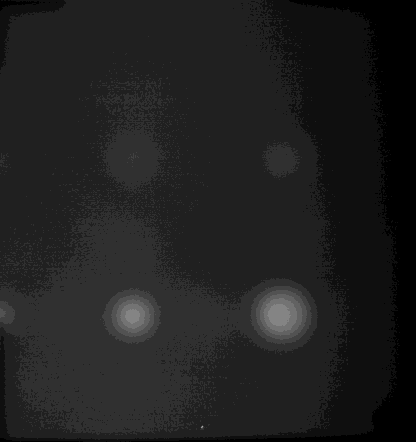

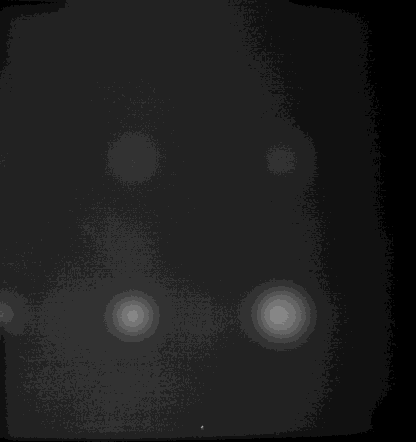

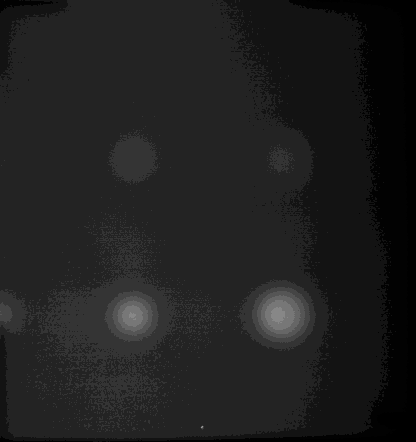

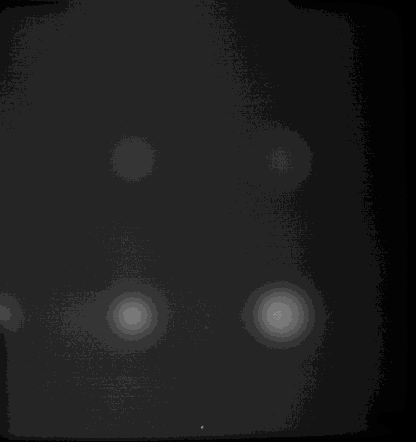

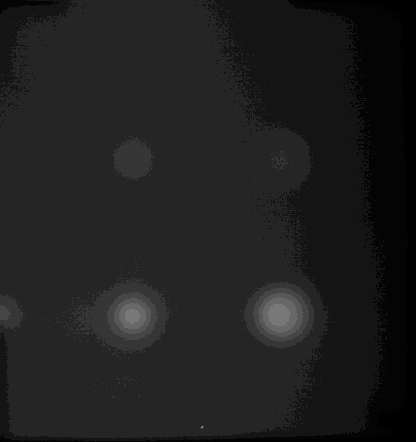

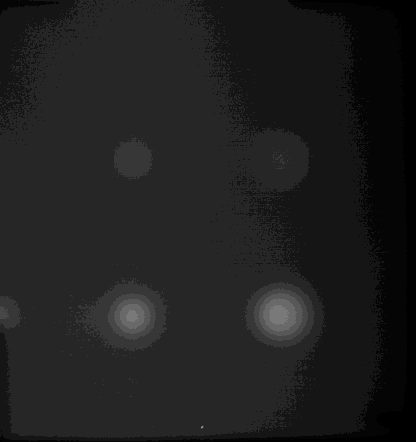

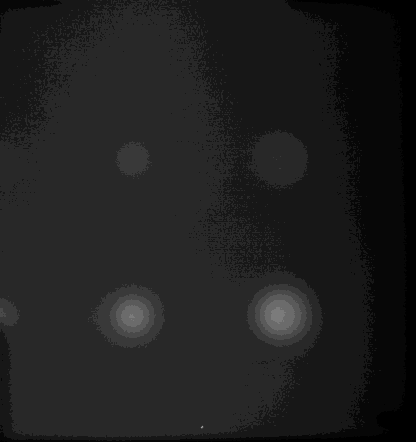

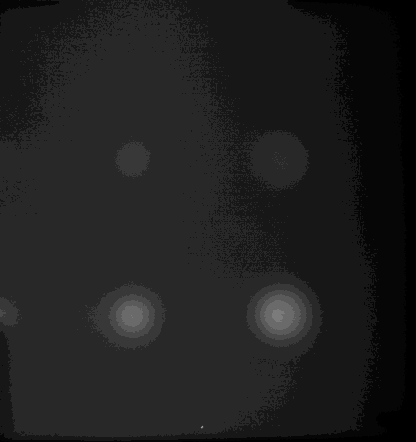

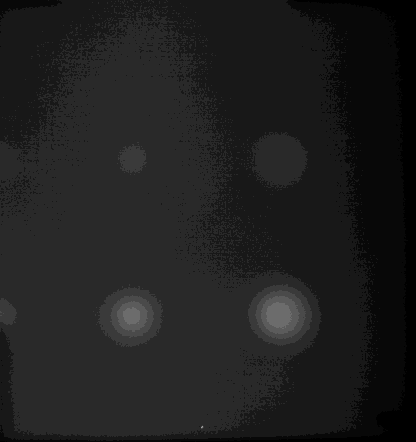

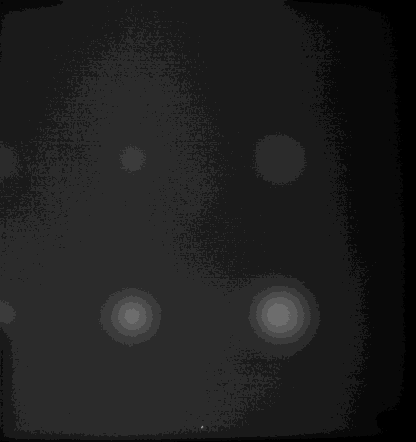

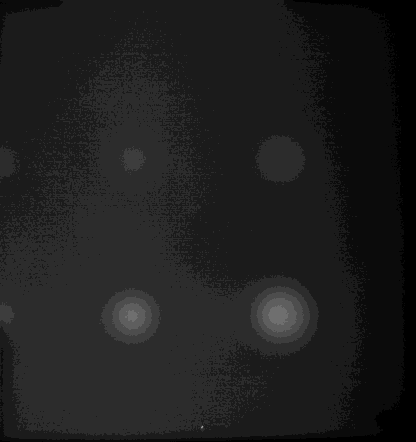

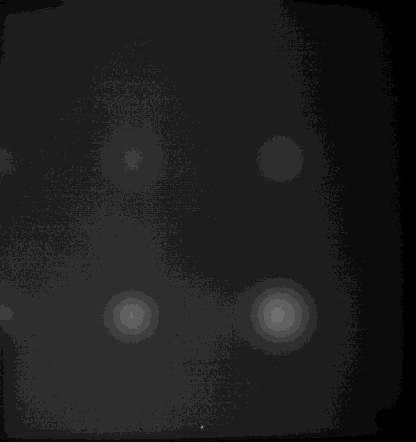

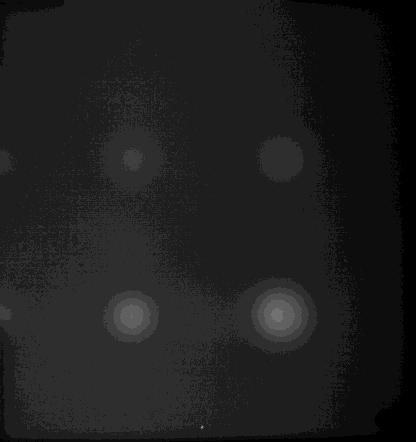

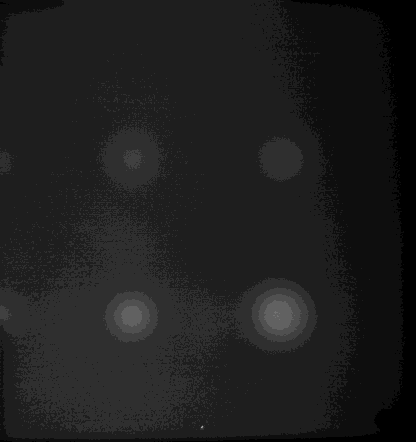

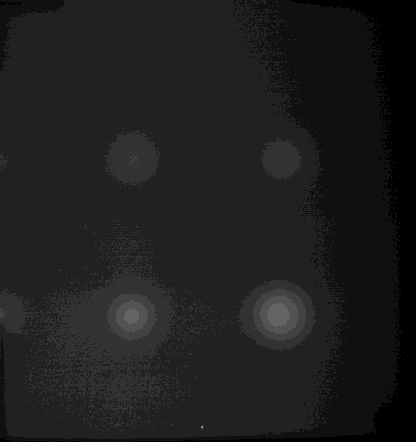

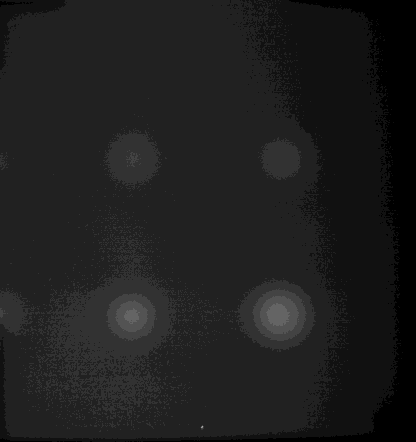

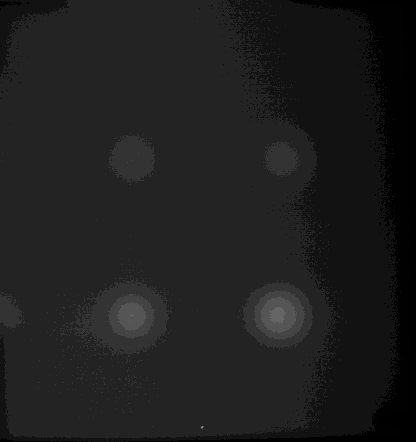

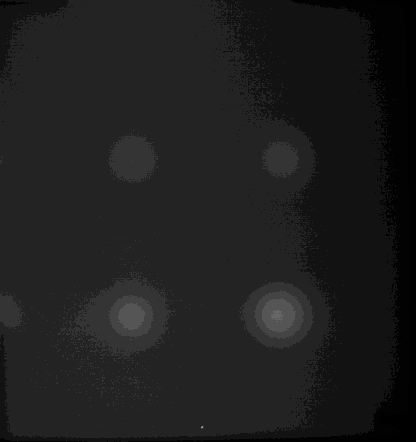

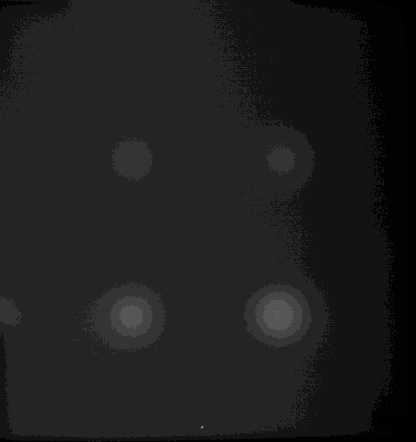

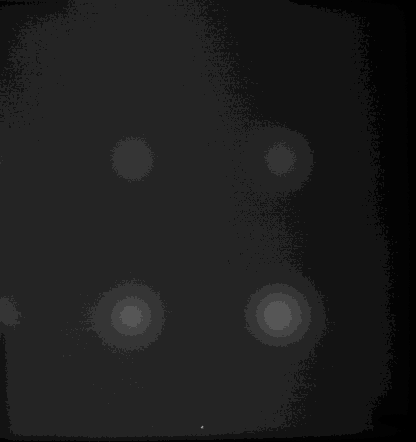

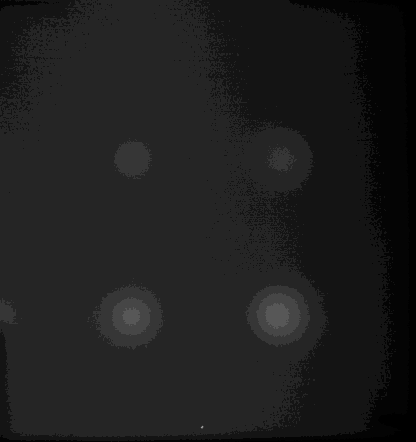

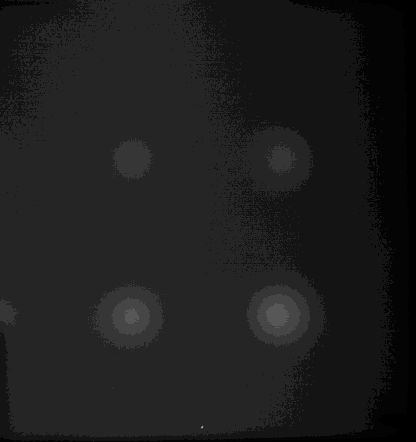

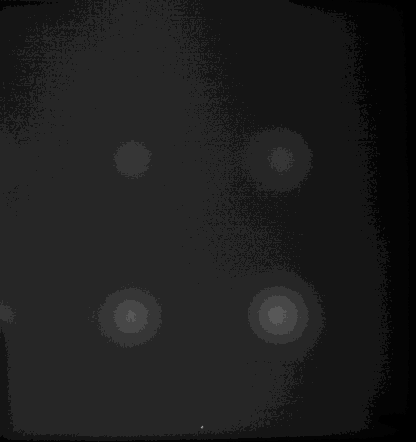

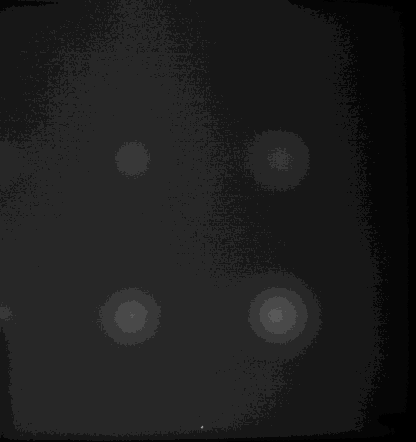

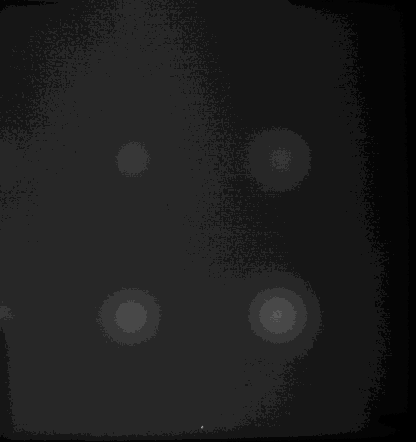

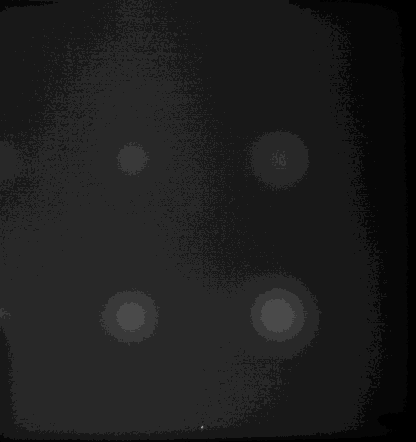

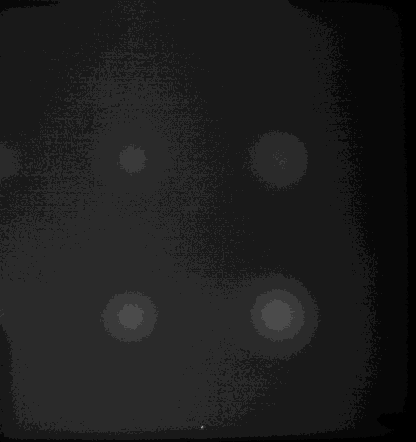

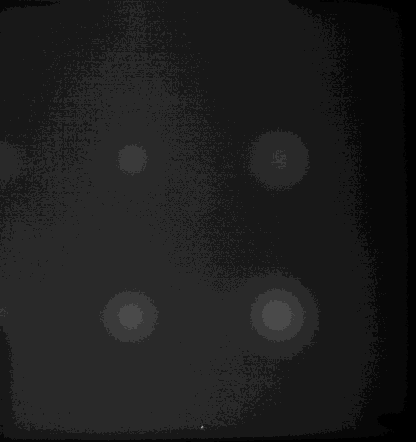

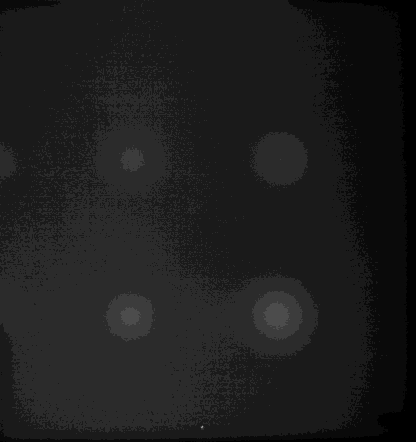

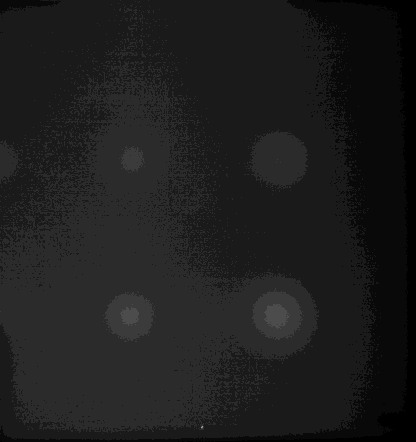

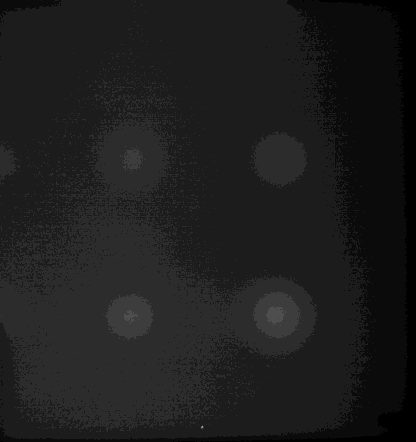

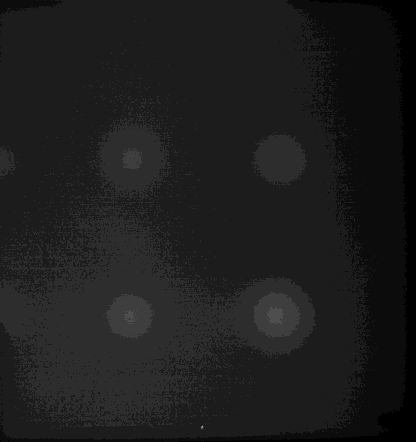

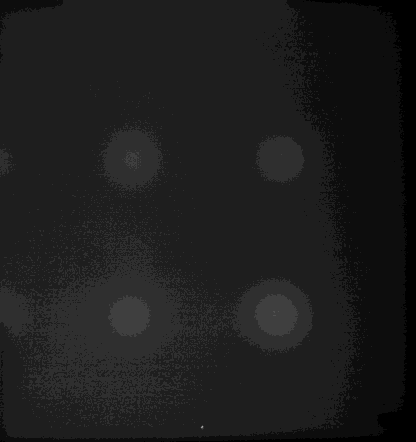

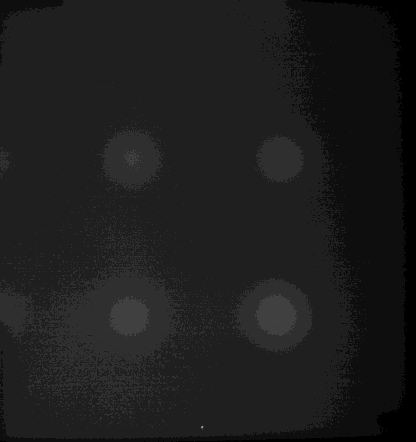

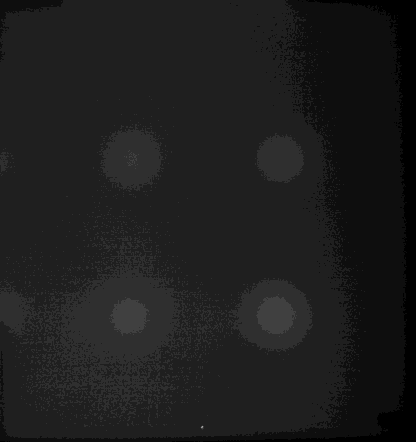

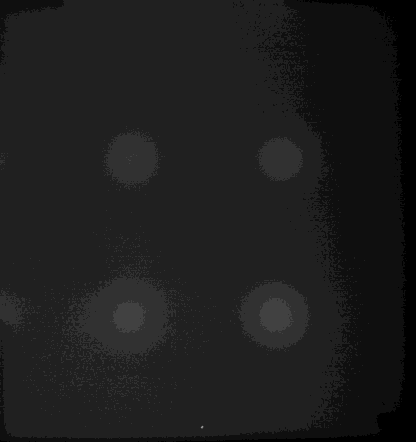

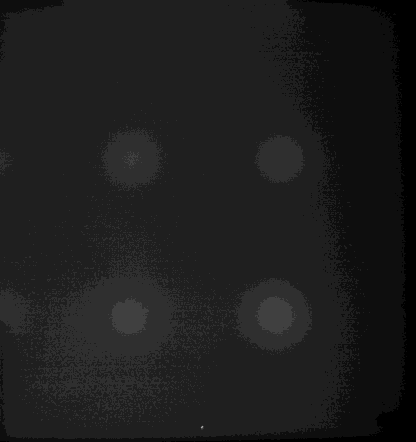

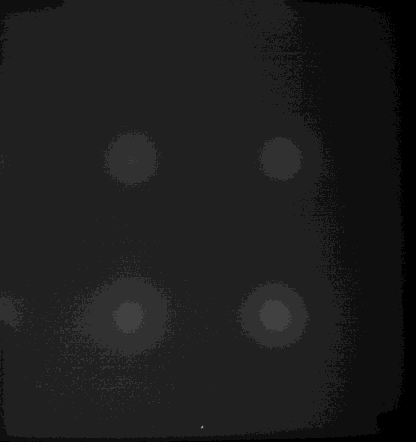

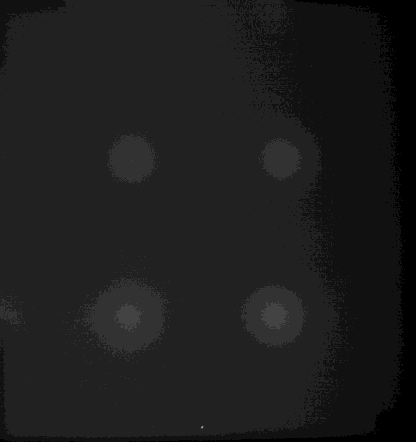

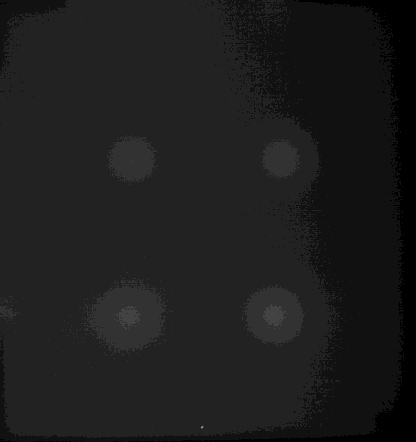

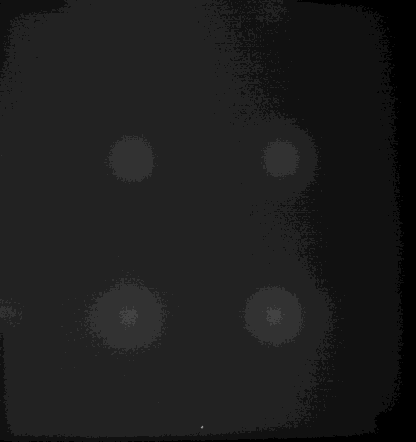

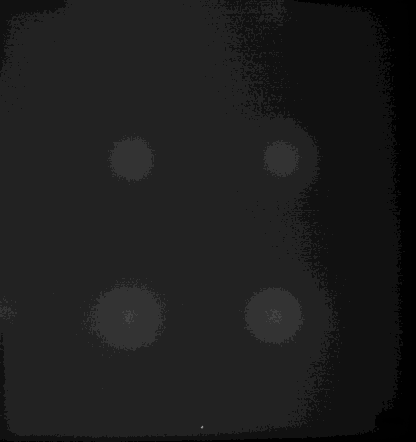

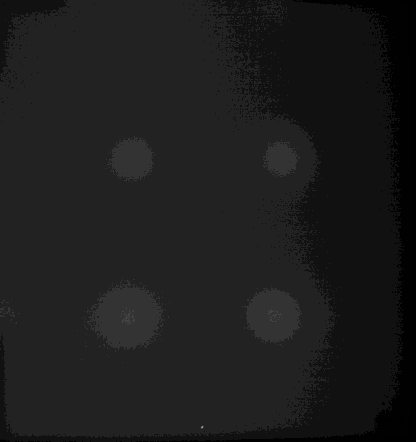

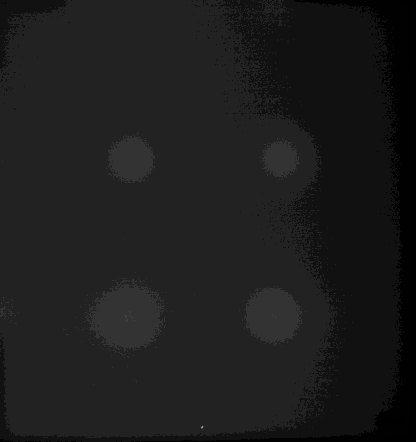

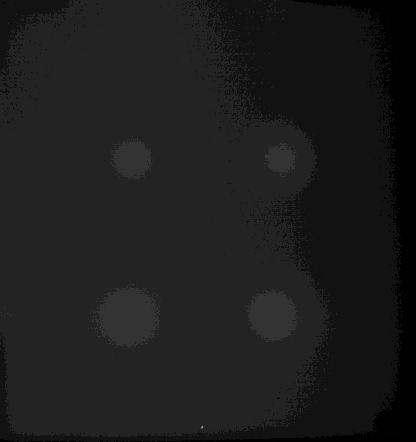

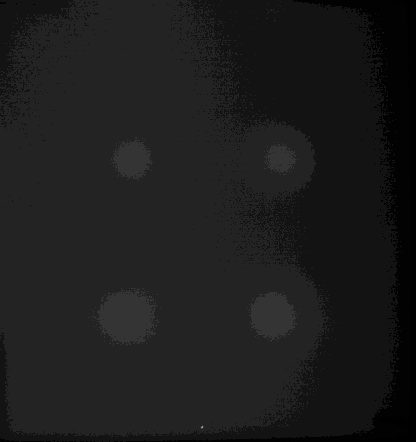

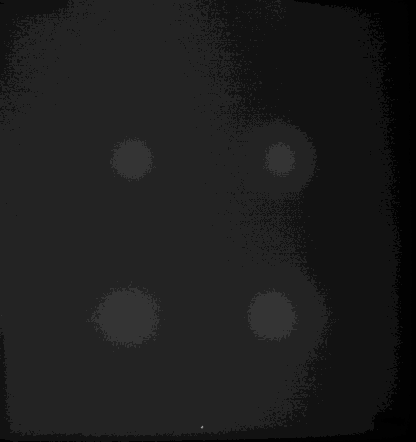

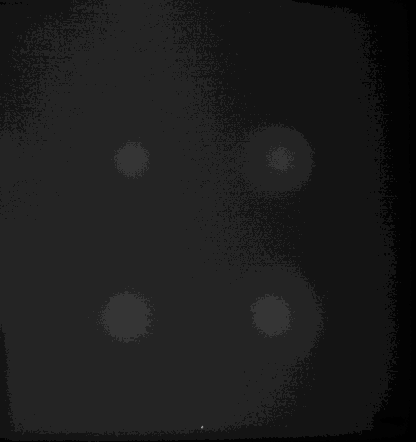

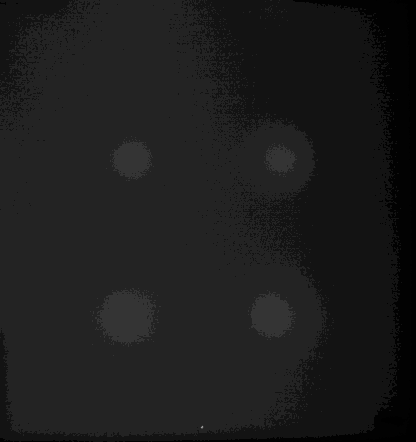

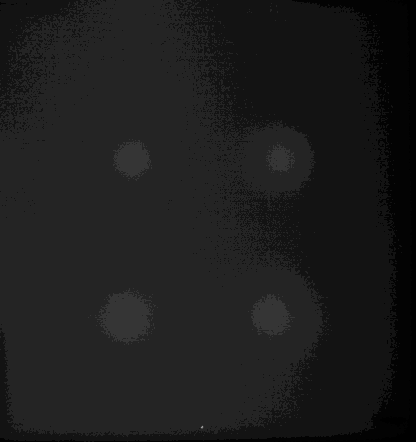

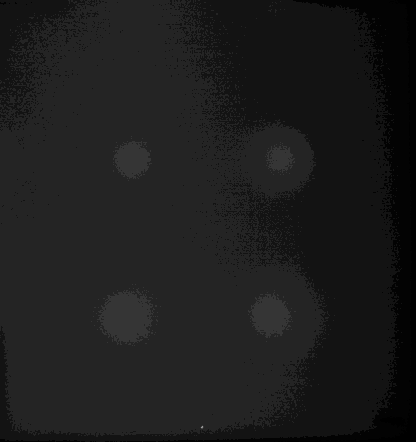

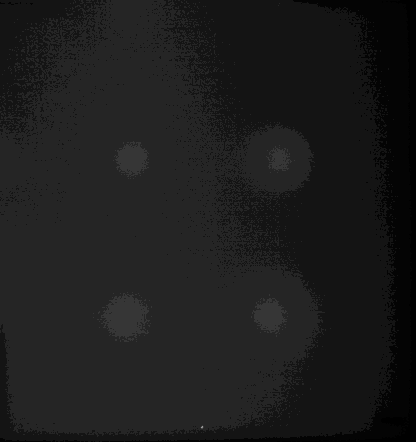

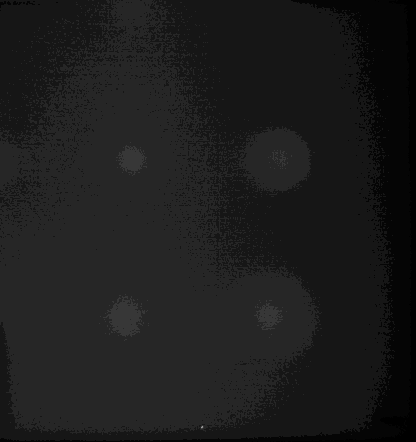

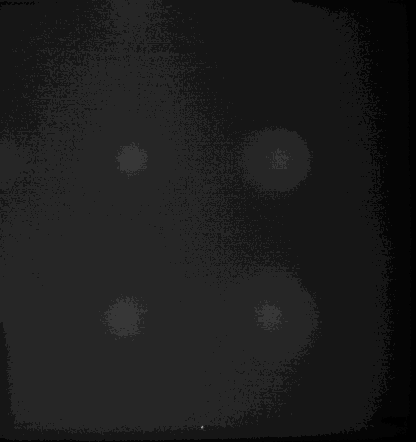

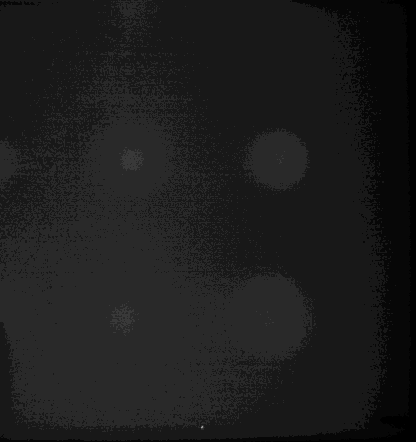

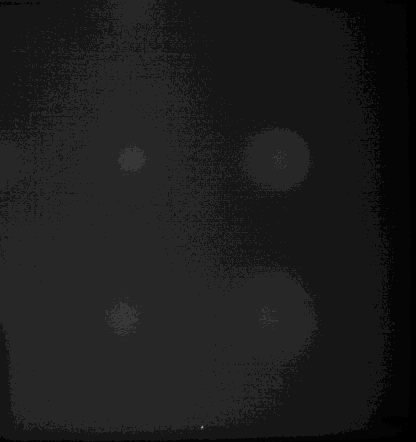

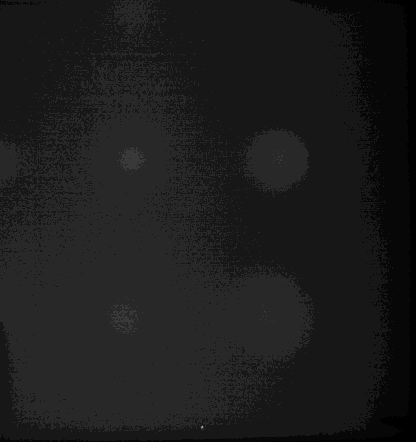

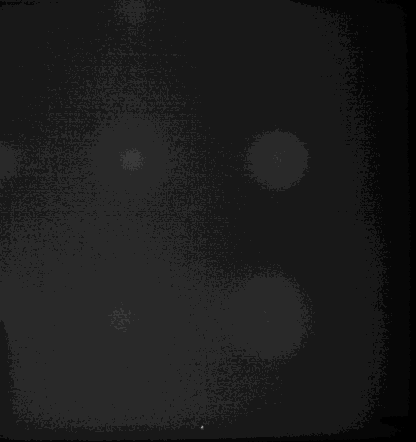

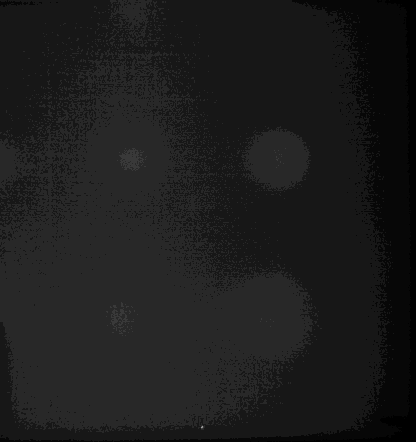

[,
 ,
 ,
 ,
 ,
 ,
 ,
 ,
 ,
 ,
 ,
 ,
 ,
 ,
 ,
 ,
 ,
 ,
 ,
 ,
 ,
 ,
 ,
 ,
 ,
 ,
 ,
 ,
 ,
 ,
 ,
 ,
 ,
 ,
 ,
 ,
 ,
 ,
 ,
 ,
 ,
 ,
 ,
 ,
 ,
 ,
 ,
 ,
 ,
 ,
 ,
 ,
 ,
 ,
 ,
 ,
 ,
 ,
 ,
 ,
 ,
 ,
 ,
 ,
 ,
 ,
 ,
 ,
 ,
 ,
 ,
 ,
 ,
 ,
 ,
 ,
 ,
 ,
 ,
 ,
 ,
 ,
 ,
 ,
 ,
 ,
 ,
 ,
 ,
 ,
 ,
 ,
 ,
 ,
 ,
 ,
 ,
 ,
 ,
 ]

In [74]:
[Timage(array=contrast(get_timage(n).array, 0.94)) for n in range(0, 1000, 10)]